In [14]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import cPickle as pickle
from spiketopics.helpers import *

%matplotlib inline
sns.set_style('darkgrid')

# Load in data

In [15]:
infile = 'data/fitted_model_object.pkl'
gpm = pickle.load(open(infile, 'rb'))
dt = 0.020

In [16]:
gpm.Nframe.head()

,unit,time,count,lam0,lam1
0,2,1701,1,-0.474867,-0.493637
1,9,1701,1,-0.124004,-0.086364
2,0,1701,1,-0.273266,-0.263279
3,0,1701,0,-0.273266,-0.277164
4,0,1701,1,-0.273266,-0.263279


In [17]:
if gpm.regressors:
    gpm.Xframe.head()

# Plot inferred categories as matrix

In [18]:
xi = gpm.nodes['HMM'].nodes['z'].z[1]
T, K = xi.shape
print xi.shape

(2970, 20)


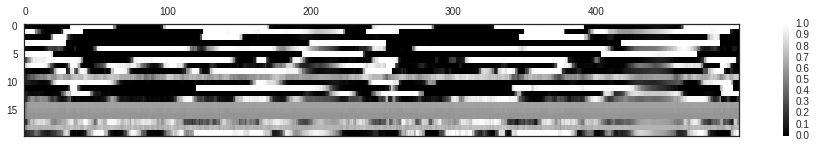

In [19]:
matshow(xi[:500].T, vmin=0, vmax=1);
plt.colorbar();

## Make $\xi$ dataframe:

In [20]:
xif = pd.DataFrame(xi)
xif.columns = ['Z' + str(k) for k in range(K)]
xif.index.name = 'time'
xif = xif.reset_index()

# Posteriors for effects

## Baselines

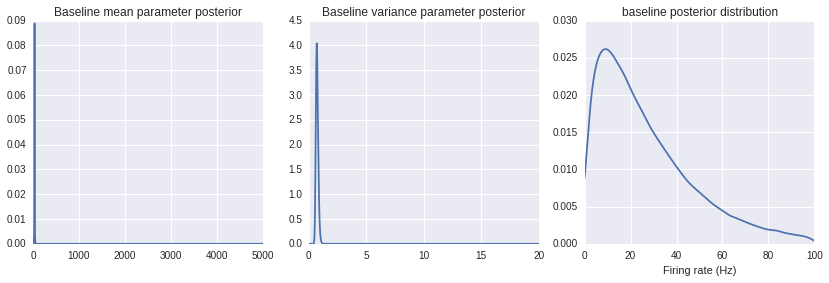

In [21]:
plt.figure(figsize=(14, 4))

th = gpm.nodes['baseline_mean']
cc = gpm.nodes['baseline_shape']
th_pars = [th.post_shape, th.post_rate]
cc_pars = [cc.post_shape, cc.post_rate]
samples = gamma_from_hypers(th_pars, cc_pars, 1e5)

plt.subplot(1, 3, 1)
xx = np.linspace(0, 5000, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0], scale=th_pars[1]/dt))
plt.title('Baseline mean parameter posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 20, 500)
plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0], scale=cc_pars[1]))
plt.title('Baseline variance parameter posterior');

plt.subplot(1, 3, 3)
sns.kdeplot(samples / dt, gridsize=1e4, clip=(0, 100))
plt.title('baseline posterior distribution')
plt.xlabel('Firing rate (Hz)')
plt.xlim(0, 100);

## Regressors

In [22]:
if gpm.regressors:
    plt.figure(figsize=(8, 6));
    inferred_means = gpm.nodes['fr_regressors'].expected_x()
    R = inferred_means.shape[1]
    for r in xrange(R):
        plt.hist(inferred_means[:, r], bins=50, normed=True, alpha=0.25, label='X' + str(r))
    plt.title('Regression effects');
    plt.legend()
    plt.ylim(0, 5);
    plt.xlim(0, 5);

## Latent Categories

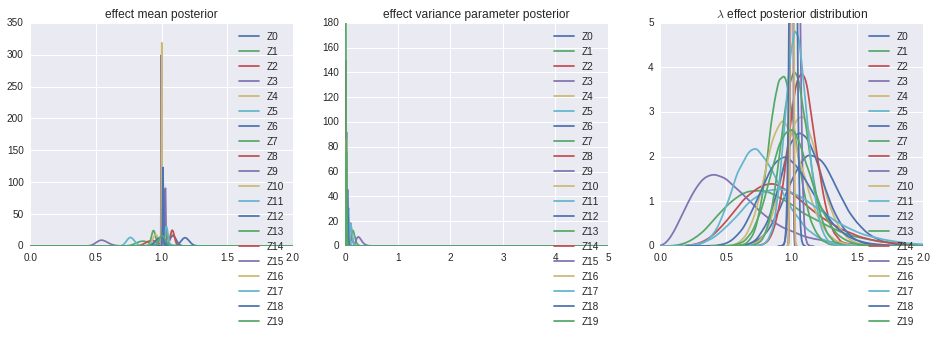

In [23]:
plt.figure(figsize=(16, 4))

th = gpm.nodes['fr_latents_mean']
cc = gpm.nodes['fr_latents_shape']

th_pars = np.c_[th.post_shape, th.post_rate].T
cc_pars = np.c_[cc.post_shape, cc.post_rate].T

plt.subplot(1, 3, 1)
xx = np.linspace(0, 2, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=th_pars[0, kk], scale=th_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect mean posterior');

plt.subplot(1, 3, 2)
xx = np.linspace(0, 5, 500)
for kk in xrange(K):
    plt.plot(xx, stats.invgamma.pdf(xx, a=cc_pars[0, kk], scale=cc_pars[1, kk]), label='Z' + str(kk))
plt.legend()
plt.title('effect variance parameter posterior');

plt.subplot(1, 3, 3)
for kk in xrange(K):
    samples = gamma_from_hypers(th_pars[:, kk], cc_pars[:, kk], 1e5)
    sns.kdeplot(samples, gridsize=1e4, clip=(0, 10), label='Z' + str(kk))
plt.legend()
plt.title(r'$\lambda$ effect posterior distribution')
plt.xlim(0, 2);
plt.ylim(0, 5);

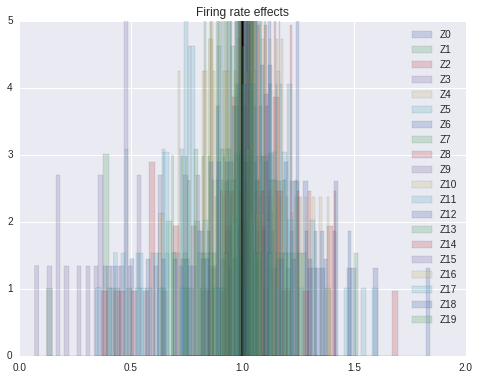

In [24]:
plt.figure(figsize=(8, 6))

inferred_effects = gpm.nodes['fr_latents'].expected_x()
for kk in xrange(K):
    plt.hist(inferred_effects[..., kk], bins=50, normed=True, alpha=0.25, label='Z' + str(kk));
plt.legend();
plt.title('Firing rate effects');
plt.ylim(0, 5);

## Overdispersion

In [25]:
if gpm.overdispersion:
    plt.figure(figsize=(8, 6))

    inferred_means = gpm.nodes['overdispersion'].expected_x().ravel()
    plt.hist(inferred_means, bins=500, normed=True, alpha=0.25);
    plt.title('Overdispersion effects');
    plt.ylim(0, 2);

# Load and prepare ethogram:

Our goal here is to load the ethogram, join it to the inferred ethogram, and perform some comparisons to see if any of our discovered categories match hand-labeled categories from the ethogram.

In [26]:
ethofile = 'sql/etho.csv'
etho = pd.read_csv(ethofile)

IOError: File sql/etho.csv does not exist

In [ ]:
# rename some columns
etho = etho.rename(columns={'movieId': 'movie', 'frameNumber': 'frame'})
etho = frames_to_times(etho)

In [ ]:
etho.head()

In [ ]:
# merge labeled and inferred etho on movie and frame columns
edf = pd.merge(etho, xif, how='right')
edf.columns

In [ ]:
# get rid of categories that are either identifiers or have non-binary entries
edf = edf.drop(['frameTime', 'ethoCameraLabel', 'ethoFaceLabel',
                'ethoGenitalsLabel', 'ethoForageLabel', 'ethoAggressionLabel', 'time',
                'ethoCameraLevel',
                'ethoRoughCountLabel', 'ethoRoughCountLevel', 'ethoFaceViewLevel', 
                'ethoGenitalsViewLevel', 'ethoForageLevel', 'ethoAggressionLevel'], axis=1)


In [ ]:
edf.head()

# View results:

In [ ]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

## Overlap analysis:

Define the overlap as the maximum of the match or mismatch percentage. That is, if $x$ and $y$ are binary vectors, 
$$
\mathrm{overlap} = \max \{ \mathbb{E}[xy + (1-x)(1-y)], \mathbb{E}[(1-x)y + x(1-y)]\}
$$

In [ ]:
match = (edf.T.dot(edf) + (1 - edf.T).dot(1 - edf)) / T
mismatch = (edf.T.dot(1 - edf) + (1 - edf.T).dot(edf)) / T
overlap = np.maximum(match, mismatch)

In [ ]:
row_labels = edf.columns[:]
matshow(overlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

In [ ]:
overlap.iloc[-K:, :]

Try using the MPM (maximizer of posterior marginals) rather than the posterior:

In [ ]:
# round to 0 or 1 elementwise
medf = np.around(edf)

In [ ]:
# plot a section in time; each row is a regressor; bottom rows are inferred categories
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

In [ ]:
mmatch = (medf.T.dot(medf) + (1 - medf.T).dot(1 - medf)) / T
mmismatch = (medf.T.dot(1 - medf) + (1 - medf.T).dot(medf)) / T
moverlap = np.maximum(mmatch, mmismatch)

In [ ]:
row_labels = medf.columns[:]
matshow(moverlap.values[-K:,:]) #, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5)
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');
plt.gcf().set_size_inches([20, 5])

In [ ]:
moverlap.iloc[-K:, :]

In [ ]:
moverlap.iloc[-K:, :-K].max()

### What is chance overlap?

How much overlap should we expect by chance, simply based on raw statistics? Let's generate some sequences from the fitted model and look at their overlap.

In [ ]:
A = gpm.nodes['HMM'].nodes['A']
pi = gpm.nodes['HMM'].nodes['pi']
dnode = gpm.nodes['HMM'].nodes['d']

In [ ]:
def get_duration(mu, lam, shape, rate):
    """
    Given tuple of normal-gamma parameters, draw a duration (max = D) from
    the appropriate lognormal distribution.
    """
    while True:
        d = lognormal_from_hypers(mu, lam, shape, rate, 1)
        if (d >= 1) and (d <= gpm.D):
            break
    
    return d

In [ ]:
def make_chain(A, pi, mu, lam, shape, rate):
    """
    Generate a latent state sequence. A and pi are Markov parameters. Other
    arguments specify normal-gamma hyperparameters to a lognormal duration 
    distribution.
    """

    chain = np.empty((T,))

    # initialize
    t = 0
    while t < T:
        if t == 0:
            pp = pi[1]
        else:
            pp = A[1, chain[t - 1]]

        # pick a new state
        z = stats.bernoulli.rvs(pp, size=1)

        # pick a duration
        d = get_duration(mu[z], lam[z], shape[z], rate[z]).astype('int')
        d = np.min([d, gpm.T - d])

        # fill in the next d steps of the chain
        chain[t:(t+d)] = z
        t += d
            
    return chain

In [ ]:
def generate_fake_chains(nfake):
    fakechains = np.empty((T, K * nfake))

    for kk in xrange(K):

        # draw nfake transition matrices from posterior
        fakeA = np.empty(A.post.shape[:2] + (nfake,))
        for idx in xrange(fakeA.shape[1]):
            fakeA[:, idx, :] = stats.dirichlet.rvs(A.post[:, idx, kk], size=nfake).T

        # same for pi
        fakepi = np.empty(pi.post.shape[:1] + (nfake,))
        fakepi = stats.dirichlet.rvs(pi.post[..., kk], size=nfake).T

        # get poster parameters for duration distribution
        mu = dnode.parent.post_mean[:, kk]
        lam = dnode.parent.post_scaling[:, kk]
        alpha = dnode.parent.post_shape[:, kk]
        beta = dnode.parent.post_rate[:, kk]

        for idx in xrange(nfake):
            fakechains[:, kk * nfake + idx] = make_chain(fakeA[..., idx], fakepi[..., idx], mu, lam, alpha, beta)

    return fakechains

In [ ]:
%%time
nfake = 100  # number of fake sequences for each chain
fchains = generate_fake_chains(nfake)

In [ ]:
trng = slice(1500, 2000)
matshow(edf.iloc[trng, :-K].values.T, vmin=0, vmax=1);

# zoom in on inferred
matshow(edf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use MPM
matshow(medf.iloc[trng, -K:].values.T, vmin=0, vmax=1);

# use fake chains
matshow(fchains[trng].T, vmin=0, vmax=1);
plt.gcf().set_size_inches([18, 4])

Calculate overlap with actual ethogram:

In [ ]:
fmatch = (edf.T.dot(fchains) + (1 - edf.T).dot(1 - fchains)) / T
fmismatch = (edf.T.dot(1 - fchains) + (1 - edf.T).dot(fchains)) / T
foverlap = np.maximum(fmatch, fmismatch)

In [ ]:
row_labels = edf.columns[:]
matshow(foverlap.values.T, vmin=0.5, vmax=1)
plt.ylabel('inferred factor')
plt.xlabel('labeled factor')
plt.colorbar();

# add column names
ax = plt.gca()
ax.xaxis.set_label_position('top')
plt.tick_params(axis='x', which='both', top='off', bottom='off', 
                labelbottom='on', labeltop='off', pad=5);
plt.xticks(xrange(len(row_labels)), row_labels, rotation='vertical', horizontalalignment='center');

plt.gcf().set_size_inches([20, 8])

In [ ]:
foverlap.max(axis=1)

In [ ]:
foverlap.mean(axis=1)

In [ ]:
fov = foverlap.T.iloc[:, :-K] * 100
mov = moverlap.iloc[-K:, :-K] * 100
with sns.axes_style('whitegrid'):
    # plot data from the null distribution
    sns.boxplot(fov, vert=False, whis=1000, color='gray', label='Null\nDistribution')
    
    colors = sns.color_palette(name='Set2', n_colors=K)
    # plot data from fitted categories
    for idx in range(mov.shape[0]):
        dat = mov.iloc[idx].values
        label = 'Feature {}'.format(idx)
        plt.scatter(dat, np.arange(dat.size) + 1, color=colors[idx], label=label)
        
    plt.xlim(50, 100)
    plt.title('Data-derived features match expert labels better than random features')
    plt.xlabel('(Unsigned) Percent Overlap with Expert Label')
    plt.ylabel('Expert Label')
    plt.gcf().set_size_inches([8, 20])
    plt.legend(bbox_to_anchor=(1.25, 1.0))
    plt.gcf().tight_layout()
    plt.savefig("output/figs/overlap.svg")